# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 1
repeats = 10
importance_type = "split"

life_history = ["lifespan"] #, "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']


In [3]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics

In [8]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [9]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [10]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [11]:
from loguru import logger
logger.add(locations.logs / "stage_two_shap_selection.log", rotation="12:00")     # New file is created each day at noon

1

In [12]:
stage_2_folder = locations.interim.dir / "stage_2" 
stage_2_folder.mkdir(exist_ok=True)
partitions_folder = stage_2_folder  / "partitions"
partitions_folder.mkdir(exist_ok=True)

In [13]:
data = ExpressionDataset.from_folder(locations.interim.dir / "stage_2" / "input")
data

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 146)","(146, 37)",38,408,"(146, 2)","(38, 18)"


## Setting up features to select ##

In [14]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

Samples metadata,Species metadata,Genes,Predict label,not_validated species
"['tissue', 'species']",[],all,lifespan,[]


In [37]:
selections = OrderedDict([(trait, (data,  replace(default_selection, to_predict = trait, not_validated_species = data.min_max_trait("lifespan") ))) for trait in life_history])
selections["lifespan"][0]

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 146)","(146, 37)",38,408,"(146, 2)","(38, 18)"


### Setting up pipelines ###

In [38]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations,repeats, n_folds, n_hold_out)

In [39]:
def opt_by_trait_2(trait: str):
    return locations.interim.optimization / f"{trait}_2.sqlite"

In [40]:
print("setting up quick pipelines")
quick_pipelines =  {trait:factory.make_shap_pipeline(study_path = opt_by_trait_2(trait), study_name=f"{trait}_r2_huber_kendall") for trait in life_history}
print("setting up pipelines with repeats")
pipelines = {trait:factory.make_repeated_shap_pipeline(study_path = opt_by_trait_2(trait), study_name=f"{trait}_r2_huber_kendall") for trait in life_history}
#pipelines = {trait:factory.make_shap_pipeline(trait) for trait in life_history}

#make_partitioning_shap_pipeline
pipelines.keys()

setting up quick pipelines
loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_2.sqlite


create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-09-21 00:08:25,136] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.
MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


setting up pipelines with repeats
loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_2.sqlite


[I 2020-09-21 00:08:26,591] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


dict_keys(['lifespan'])

# Run second stage #

In [41]:
stage_two = {}

In [42]:
def run_stage_two(trait: str, quick: bool = False):
    pipes = quick_pipelines if quick else pipelines
    result = pipes[trait].fit_transform(selections[trait])
    stage_two[trait] = result #ugly mutation of stage_one dicionary
    return result

In [43]:
lifespan_2 = run_stage_two("lifespan", False)
lifespan_2.selected

2020-09-21 00:08:28.027 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 0 =====
2020-09-21 00:08:28.028 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-21 00:08:28.031 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[226]	valid_0's l1: 7.18737	valid_0's l2: 148.76	valid_0's huber: 6.12487


2020-09-21 00:08:28.228 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[202]	valid_0's l1: 3.77153	valid_0's l2: 56.0594	valid_0's huber: 3.04825


2020-09-21 00:08:28.648 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.14869	valid_0's l2: 28.4208	valid_0's huber: 2.49559
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 3.14854	valid_0's l2: 28.4234	valid_0's huber: 2.49554


2020-09-21 00:08:28.836 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.05417	valid_0's l2: 45.6808	valid_0's huber: 2.44377
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.05417	valid_0's l2: 45.6808	valid_0's huber: 2.44377


2020-09-21 00:08:46.819 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9079250760643227, MAE=4.290402809446297, MSE=69.73079140567025, huber=3.5271711353604216)
2020-09-21 00:08:46.827 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 1 =====
2020-09-21 00:08:46.827 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-21 00:08:46.831 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.07125	valid_0's l2: 23.0329	valid_0's huber: 2.42301
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.07125	valid_0's l2: 23.0329	valid_0's huber: 2.42301


2020-09-21 00:08:47.030 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[213]	valid_0's l1: 4.30193	valid_0's l2: 65.1493	valid_0's huber: 3.51995


2020-09-21 00:08:47.201 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 2.31424	valid_0's l2: 16.8982	valid_0's huber: 1.74365
Did not meet early stopping. Best iteration is:
[247]	valid_0's l1: 2.31419	valid_0's l2: 16.9087	valid_0's huber: 1.74361


2020-09-21 00:08:47.432 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[224]	valid_0's l1: 5.57373	valid_0's l2: 120.793	valid_0's huber: 4.69001


2020-09-21 00:09:03.866 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.919419905560026, MAE=3.815276071861677, MSE=56.470929416377814, huber=3.092081920038261)
2020-09-21 00:09:03.873 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 2 =====
2020-09-21 00:09:03.873 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-21 00:09:03.877 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[142]	valid_0's l1: 2.6811	valid_0's l2: 16.2549	valid_0's huber: 2.06686


2020-09-21 00:09:04.034 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 4.57093	valid_0's l2: 58.9981	valid_0's huber: 3.75927


2020-09-21 00:09:04.185 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's l1: 2.89894	valid_0's l2: 22.3749	valid_0's huber: 2.27756


2020-09-21 00:09:04.347 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's l1: 5.88068	valid_0's l2: 82.4554	valid_0's huber: 4.9163


2020-09-21 00:09:17.110 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9238534009066546, MAE=4.0079122141267085, MSE=45.0208408400175, huber=3.2546844822016148)
2020-09-21 00:09:17.117 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 3 =====
2020-09-21 00:09:17.118 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-21 00:09:17.121 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 3.37239	valid_0's l2: 30.3334	valid_0's huber: 2.68356


2020-09-21 00:09:17.211 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[212]	valid_0's l1: 6.14975	valid_0's l2: 99.9848	valid_0's huber: 5.176


2020-09-21 00:09:17.388 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.10386	valid_0's l2: 28.4287	valid_0's huber: 2.44274
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 3.1036	valid_0's l2: 28.4214	valid_0's huber: 2.44226


2020-09-21 00:09:17.595 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 2.29392	valid_0's l2: 34.4478	valid_0's huber: 1.72623


2020-09-21 00:09:30.167 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9343313486831615, MAE=3.729916904723438, MSE=48.29687190102623, huber=3.004618550496779)
2020-09-21 00:09:30.174 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 4 =====
2020-09-21 00:09:30.175 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-21 00:09:30.178 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of ar

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[232]	valid_0's l1: 2.84449	valid_0's l2: 26.2916	valid_0's huber: 2.23948


2020-09-21 00:09:30.390 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[224]	valid_0's l1: 3.48889	valid_0's l2: 55.9047	valid_0's huber: 2.80947


2020-09-21 00:09:30.588 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.5234	valid_0's l2: 30.9305	valid_0's huber: 2.85848
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.5234	valid_0's l2: 30.9305	valid_0's huber: 2.85848


2020-09-21 00:09:30.793 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 5.78655	valid_0's l2: 100.493	valid_0's huber: 4.8565
Did not meet early stopping. Best iteration is:
[247]	valid_0's l1: 5.78432	valid_0's l2: 100.448	valid_0's huber: 4.85422


2020-09-21 00:09:48.546 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9269195583260895, MAE=3.9102762087538308, MSE=53.39359783501578, huber=3.1895393963324645)
2020-09-21 00:09:48.551 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 5 =====
2020-09-21 00:09:48.552 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-21 00:09:48.556 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead o

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's l1: 2.71568	valid_0's l2: 20.2566	valid_0's huber: 2.08604


2020-09-21 00:09:48.710 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 4.36411	valid_0's l2: 81.363	valid_0's huber: 3.59151
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 4.36411	valid_0's l2: 81.363	valid_0's huber: 3.59151


2020-09-21 00:09:48.903 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 4.98208	valid_0's l2: 99.092	valid_0's huber: 4.15005
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 4.98208	valid_0's l2: 99.092	valid_0's huber: 4.15005


2020-09-21 00:09:49.114 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.9887	valid_0's l2: 59.4495	valid_0's huber: 3.26846
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 3.98788	valid_0's l2: 59.4074	valid_0's huber: 3.26686


2020-09-21 00:10:05.240 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9110400890563054, MAE=4.0124362327219085, MSE=65.0297574853613, huber=3.273422190972078)
2020-09-21 00:10:05.245 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 6 =====
2020-09-21 00:10:05.246 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-21 00:10:05.249 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it i

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's l1: 2.87804	valid_0's l2: 23.6092	valid_0's huber: 2.27435


2020-09-21 00:10:05.392 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.44046	valid_0's l2: 42.1826	valid_0's huber: 2.78326
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 3.44032	valid_0's l2: 42.1856	valid_0's huber: 2.78309


2020-09-21 00:10:05.575 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 2.46988	valid_0's l2: 17.6123	valid_0's huber: 1.90019
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.46988	valid_0's l2: 17.6123	valid_0's huber: 1.90019


2020-09-21 00:10:05.763 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's l1: 3.57993	valid_0's l2: 51.9098	valid_0's huber: 2.88004


2020-09-21 00:10:22.798 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9524097864223044, MAE=3.0920411036918254, MSE=33.829222928883866, huber=2.4577636591595766)
2020-09-21 00:10:22.807 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 7 =====
2020-09-21 00:10:22.807 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-21 00:10:22.811 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argu

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's l1: 3.07172	valid_0's l2: 23.3819	valid_0's huber: 2.41159


2020-09-21 00:10:22.946 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's l1: 3.4374	valid_0's l2: 38.08	valid_0's huber: 2.74724


2020-09-21 00:10:23.093 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[191]	valid_0's l1: 3.32348	valid_0's l2: 30.7661	valid_0's huber: 2.65977


2020-09-21 00:10:23.242 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[199]	valid_0's l1: 3.48005	valid_0's l2: 46.2356	valid_0's huber: 2.81824


2020-09-21 00:10:37.660 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9516003102193499, MAE=3.3281625611286163, MSE=34.6158975938359, huber=2.657698430265163)
2020-09-21 00:10:37.666 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 8 =====
2020-09-21 00:10:37.667 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-21 00:10:37.670 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argume

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's l1: 2.59217	valid_0's l2: 18.4038	valid_0's huber: 2.01415


2020-09-21 00:10:37.824 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[228]	valid_0's l1: 3.3027	valid_0's l2: 36.0192	valid_0's huber: 2.62887


2020-09-21 00:10:38.001 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[225]	valid_0's l1: 2.7737	valid_0's l2: 25.329	valid_0's huber: 2.17984


2020-09-21 00:10:38.184 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[222]	valid_0's l1: 3.00012	valid_0's l2: 43.8522	valid_0's huber: 2.35724


2020-09-21 00:10:54.644 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9559458299704278, MAE=2.917174509523142, MSE=30.901042052896663, huber=2.2940196723803865)
2020-09-21 00:10:54.651 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 9 =====
2020-09-21 00:10:54.651 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-21 00:10:54.655 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it inst

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's l1: 3.1889	valid_0's l2: 28.0251	valid_0's huber: 2.54448


2020-09-21 00:10:54.818 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[225]	valid_0's l1: 4.58513	valid_0's l2: 72.4298	valid_0's huber: 3.78292


2020-09-21 00:10:54.997 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's l1: 3.68642	valid_0's l2: 39.9613	valid_0's huber: 2.97377


2020-09-21 00:10:55.150 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 5.09067	valid_0's l2: 82.6408	valid_0's huber: 4.24236
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 5.09067	valid_0's l2: 82.6408	valid_0's huber: 4.24236


2020-09-21 00:11:11.488 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9242988730533338, MAE=4.137780276202359, MSE=55.76425324150944, huber=3.3853521527398893)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000204498,NFKBIL1,10.000,25.100,-0.563,31.500,-0.611,26.250,-0.454,25.500,-0.624,22.500,-0.516,25.250,-0.568,23.500,-0.427,20.000,-0.548,26.250,-0.632,24.500,-0.654,25.750,-0.601
ENSG00000010219,DYRK4,10.000,22.100,0.447,21.250,0.398,21.250,0.478,17.500,0.370,21.500,0.277,16.500,0.453,25.250,0.688,24.250,0.527,19.500,0.344,24.750,0.490,29.250,0.443
ENSG00000167515,TRAPPC2L,10.000,21.050,-0.316,15.500,-0.328,20.250,-0.461,20.500,-0.275,23.750,-0.462,21.750,-0.371,19.750,-0.191,23.000,-0.254,25.250,-0.360,17.000,-0.178,23.750,-0.276
ENSG00000165501,LRR1,10.000,20.150,0.721,24.500,0.627,19.750,0.772,15.750,0.788,13.750,0.671,21.750,0.757,26.500,0.735,16.750,0.741,21.500,0.700,11.750,0.704,29.500,0.713
ENSG00000142002,DPP9,10.000,19.050,-0.801,20.500,-0.810,19.000,-0.801,17.500,-0.781,20.500,-0.808,24.750,-0.828,20.000,-0.788,19.750,-0.782,22.250,-0.811,15.750,-0.764,10.500,-0.834
ENSG00000160948,VPS28,10.000,17.150,-0.571,13.250,-0.475,23.000,-0.591,10.750,-0.598,14.500,-0.471,25.250,-0.607,22.250,-0.622,15.750,-0.645,14.000,-0.596,18.500,-0.616,14.250,-0.491
ENSG00000023191,RNH1,10.000,16.775,-0.605,14.500,-0.690,16.000,-0.509,11.500,-0.575,17.250,-0.629,13.000,-0.428,25.250,-0.694,18.500,-0.621,17.000,-0.615,19.750,-0.630,15.000,-0.658
ENSG00000165555,NOXRED1,10.000,16.000,0.816,19.000,0.698,18.250,0.787,10.250,0.816,14.500,0.858,14.750,0.854,15.250,0.837,14.000,0.815,15.750,0.847,20.500,0.820,17.750,0.824
ENSG00000137343,ATAT1,10.000,15.575,-0.593,16.000,-0.621,16.000,-0.636,14.500,-0.584,20.000,-0.588,15.750,-0.689,13.500,-0.580,10.750,-0.487,12.250,-0.494,21.000,-0.545,16.000,-0.706
ENSG00000170835,CEL,10.000,15.525,0.712,11.250,0.784,16.000,0.745,10.500,0.753,13.750,0.714,24.250,0.668,20.000,0.733,12.500,0.620,12.000,0.669,19.500,0.717,15.500,0.714


## evaluate metrics ###

In [51]:
lifespan_2.metrics_average

Metrics(R2=0.9307744178261974, MAE=3.7241378892179804, MSE=49.30532047005947, huber=3.0136351589946635)

In [52]:
lifespan_2.validation_metrics["R^2"].mean()

0.9418131680942363

## Check plots ##

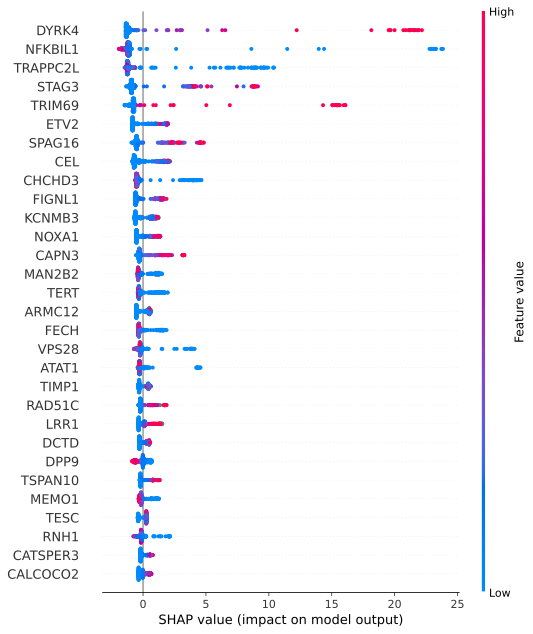

In [54]:
summary_stage_two_plot_path = locations.output.dir / "plots" / "stage_two_summary_lifespan.svg"
lifespan_2.plot(title = "second stage lifespan model", max_display=30, plot_size=0.3, save=summary_stage_two_plot_path )

min_max dataset values: (3.3, 122.5)


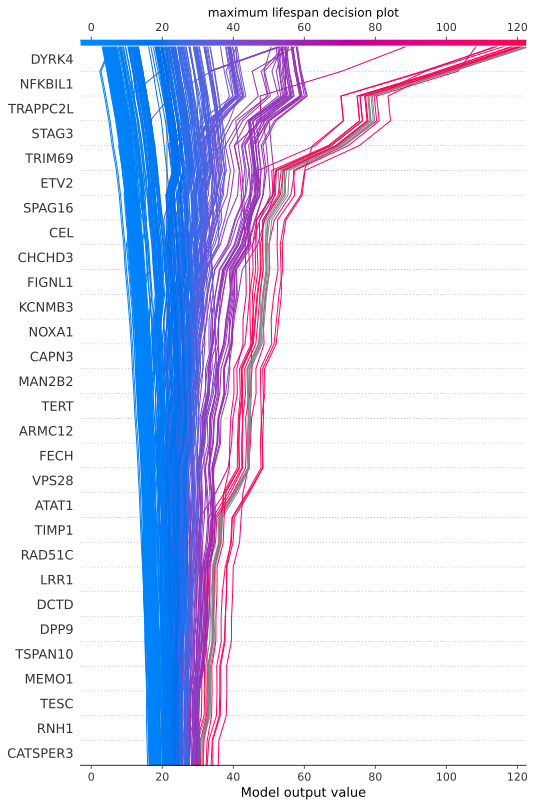

In [125]:
stage_two_decision_plot_path = locations.output.dir / "plots" / "stage_two_decision_lifespan.svg"
lifespan_2..plot_decision(save = stage_two_decision_plot_path , title = "maximum lifespan decision plot", minimum = -3, maximum=120, auto_size_plot=(1000,1000), feature_display_range=slice(-1, -30, -1))

## Save files ##

In [126]:
lifespan_2.selected.to_csv(locations.output.stage_two / "lifespan.tsv", sep="\t", index_label="reference_gene")

In [129]:
lifespan_2.write(partitions_folder , "lifespan_stage_two")

PosixPath('../data/interim/stage_2/partitions')